In [1]:
from PIL import Image
import numpy as np



先下載 MNIST 資料


In [2]:
import os
import urllib
from urllib.request import urlretrieve
dataset = 'mnist.pkl.gz'
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
    
if not os.path.isfile(dataset):
        origin = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"
        print('Downloading data from %s' % origin)
        urlretrieve(origin, dataset, reporthook=reporthook)

In [3]:
import gzip
import pickle
with gzip.open(dataset, 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [4]:
# 設定好訓練及測試資料
train_X, train_y = train_set
test_X, test_y = test_set
# 設定成我們的格式
train_X = train_X[..., None]
test_X = test_X[..., None]


In [5]:
# 有 10 種類別，輸入的是 784 維
print(train_X.shape)
np.unique(train_y)

(50000, 784, 1)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
print(train_y[:20])
showX(train_X[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [7]:
# 參考範例 softmax regression
W = np.random.normal(size=(10, 784))
b = np.random.normal(size=(10, 1))
n_data = train_X.shape[0]
# 紀錄 loss
loss_history = []
accuracy_history = []
for epoch in range(5000):    
    idx = np.random.choice(n_data, 300, replace=False)
    X = train_X[idx]
    y = train_y[idx]
    one_y = np.eye(10)[y][..., None]
    d = np.exp(W @ X + b)
    q = d/d.sum(axis=(1,2), keepdims=True)
    loss = -np.log(q[range(len(y)), y]).mean()
    loss_history.append(loss)
    accuracy = (q.argmax(axis=1).ravel() == y).mean()
    accuracy_history.append(accuracy)
    if epoch%100 == 0:
        print(epoch, accuracy, loss)
    grad_b_all = q - one_y
    grad_b = grad_b_all.mean(axis=0)
    grad_W_all = grad_b_all @ X.swapaxes(1,2)
    grad_W = grad_W_all.mean(axis=0)
    W -=  grad_W
    b -= grad_b    


0 0.0766666666667 14.7633291583
100 0.816666666667 1.12175434422
200 0.843333333333 0.833995999027
300 0.836666666667 0.835177546257
400 0.88 0.611107325334
500 0.883333333333 0.58895255329
600 0.85 0.592627160802
700 0.91 0.434092172306
800 0.863333333333 0.691631139491
900 0.893333333333 0.450643237595
1000 0.876666666667 0.540414222067
1100 0.886666666667 0.454321685261
1200 0.88 0.396094264975
1300 0.906666666667 0.421309262289
1400 0.923333333333 0.357708526954
1500 0.9 0.362439934516
1600 0.88 0.522117077438
1700 0.903333333333 0.351647223098
1800 0.913333333333 0.425166735135
1900 0.91 0.325544491018
2000 0.923333333333 0.300071820905
2100 0.943333333333 0.272346927431
2200 0.916666666667 0.293919870294
2300 0.886666666667 0.359619638404
2400 0.92 0.282819669312
2500 0.91 0.376000480436
2600 0.91 0.306211495725
2700 0.906666666667 0.380721296137
2800 0.88 0.450500091509
2900 0.913333333333 0.267039196034
3000 0.92 0.397651502979
3100 0.933333333333 0.251360549114
3200 0.93666666

In [8]:
# test data 的正確率
((W @ test_X + b).argmax(axis=1).ravel() == test_y).mean()

0.91479999999999995

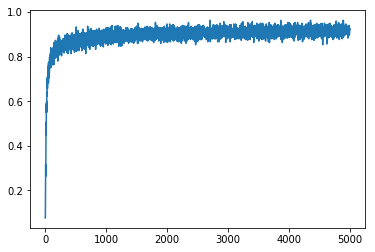

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
# 準確率的圖
plt.plot(accuracy_history);

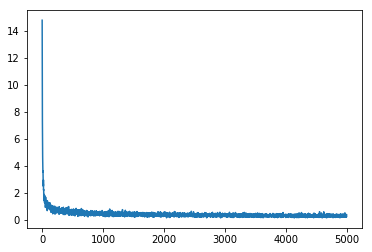

In [10]:
# loss 的圖
plt.plot(loss_history);

In [11]:
def softmax(x):
    t = np.exp(x)
    return t/t.sum(axis=(-2,-1),keepdims=True)
def relu(x):
    return np.maximum(x, 0)
def sigmoid(x):
    return 1/(1+np.exp(-x))

# 微分
def Drelu(x):
    return (x>0).astype('float32')
def Dsigmoid(x):
    q = sigmoid(x)
    return q * (1-q) 
    # or 
    #return np.exp(x)/(1+np.exp(-x))**2

In [12]:
# 參考範例 feedforward network
from time import time
accuracy_history = []
γ = 0.02
A = np.random.normal(size=(50,784))
b = np.random.normal(size=(50,1))
C = np.random.normal(size=(10,50))
d = np.random.normal(size=(10,1))
t0 = time()
for epochs in range(20):
    idx = np.random.choice(n_data, n_data, replace=False)
    for i in idx:
        x = train_X[i]
        y = train_y[i]
        U_ = A@x+b
        U = relu(U_)
        q = softmax(C@U+d)
        L = - np.log(q[y])[0]
        p = np.eye(10)[y][:, None]
        grad_d = q - p
        grad_C = grad_d @ U.T
        grad_b = (C.T @ grad_d ) * Drelu(U_)
        grad_A = grad_b @ x.T
        A -= γ * grad_A
        b -= γ * grad_b
        C -= γ * grad_C
        d -= γ * grad_d    
    score = ((C@relu(A@test_X+b)+d).argmax(axis=1).ravel()==test_y).mean()
    print(epochs, score, "%.1f"%(time()-t0), L)
print(time()-t0)

0 0.8753 6.7 0.0128507524194
1 0.9067 13.4 1.26545007815e-05
2 0.9163 20.1 0.00407199113818
3 0.9283 26.8 1.57746234793e-06
4 0.9342 33.6 0.00330959936599
5 0.9373 40.3 0.097537298761
6 0.9375 47.0 9.45099207615e-06
7 0.939 53.8 5.37520844445e-05
8 0.941 60.5 0.0578671918733
9 0.9407 67.1 2.20464913235e-09
10 0.9475 74.0 7.7697260039e-09
11 0.9443 80.7 0.000757343988081
12 0.9435 87.4 7.22283457658e-06
13 0.9427 94.1 0.00118373058708
14 0.9512 100.9 1.15282724748e-06
15 0.9465 107.5 3.94978484637e-05
16 0.9491 114.3 0.000376953392446
17 0.9467 121.0 4.67325067543e-11
18 0.9516 127.7 1.54487533877e-12
19 0.954 134.4 9.27240288853e-09
134.3613383769989
